# SQLAlchemy, ORM

Устанавливаем Алхимию

In [ ]:
!pip install sqlalchemy

Импортируем все нужное

In [ ]:
from sqlalchemy import create_engine, Table, Column, Integer, String, Date, MetaData, Sequence, insert, select, func, text, table, column

Для начала поработаем с SQLite, а потом с Postgres.

Вы увидите, что механика абсолютно не отличается, поэтому, если у вас под рукой лишь одна база данных - смело меняйте строку покдлючения и работайте с ней.

## SQLite

Создание "движка" подключения SQLite

In [ ]:
engine=create_engine('sqlite:///../Lesson 7/mydatabase.db', echo=True) # проверьте путь к файлу 

Создадим новую таблицу и заполним ее данными

In [ ]:
# Создание метаданных
metadata = MetaData()

# Определение таблицы
users_table = Table('users_new', metadata,
                    Column('id', Integer, Sequence('user_id_seq'), primary_key=True),
                    Column('name', String(50)),
                    Column('fullname', String(50)),
                    Column('age', Integer))

# Создание всех таблиц в базе данных
metadata.create_all(engine)

# Подключение к базе данных
conn = engine.connect()

# Добавление данных в таблицу
stmt = insert(users_table).values(name='Andrew', fullname='Andrew B', age=15)
conn.execute(stmt)

Ок, строка добавлена, но есть ли она в базе данных? Почему?

In [ ]:
# Добавление данных в таблицу
stmt = insert(users_table).values(name='Mettew', fullname='Mettew D', age=18)
conn.execute(stmt)
conn.commit()

А теперь? 

Добавим в таблицу больше данных. Сделать это можно, например, передав в метод `insert` список из словарей:

In [ ]:
list_users = [
    {'name': 'Daliel', 'fullname': 'Daniel M', 'age': 16},
    {'name': 'Fillip', 'fullname': 'Fillip J', 'age': 21},
    {'name': 'Anna', 'fullname': 'Anna K', 'age': 19},
    {'name': 'Anna', 'fullname': 'Anna B', 'age': 25},
]

stmt = insert(users_table).values(list_users)
conn.execute(stmt)
conn.commit()

И прочитаем их из Python

In [ ]:
# Получение всех пользователей из базы данных
stmt = select(users_table)
result = conn.execute(stmt)

for row in result:
    print(row)

через `<имя таблицы>.c.` можно обращаться к полям таблицы

In [ ]:
users_table.c.keys()

In [ ]:
users_table.c.name

С помощью SQLAlchemy вы можете конструировать SQL запрос в специфической для ORM нотации (это выглядит как применение функций) к таблицам.

Вот так можно отфильтровать и отсортировать записи:

In [ ]:
# фильтрация и сортировка
stmt = select("*").where(users_table.c.name.in_(['Andrew','Anna'])).order_by(users_table.c.age.desc())
result = conn.execute(stmt)

for row in result:
    print(row)

А вот так можно сгруппировать данные в таблице:

In [ ]:
# группировка
stmt = select(users_table.c.name, func.count()).group_by(users_table.c.name)
result = conn.execute(stmt)

for row in result:
    print(row)

Обратите внимание, что мы опускаем имя таблицы, к которой обращаемся (блок FROM для SQL запроса). ORM "додумывает" за нас из какой таблицы брать данные. 

Это не очень хорошо, далее мы так делать не будем.

Не забываем закрывать соединение:

In [ ]:
conn.close()

## PostgreSQL

Создение "движка" подключения PostgreSQL.

Обратите внимание на строку подключения.

In [ ]:
# Подключение к базе данных PostgreSQL
DATABASE_URL = "sqlite:///../Lesson 7/big_sales.db"
engine = create_engine(DATABASE_URL, echo=True)

Попробуем достать данные из существующей таблицы базы данных:

In [ ]:
# Подключение к базе данных
conn = engine.connect()

stmt = select("*").select_from(table("sales_data")).limit(10)
result = conn.execute(stmt)

for row in result:
    print(row)

# закрытие соединения
conn.close()

Однако, нам часто придется обращаться к полям таблицы, и делать это при таком обращении к самой таблице - не удобно.

Попробуем объявить таблицу как переменную:

In [ ]:
# Создание метаданных
metadata = MetaData()

# Определение таблицы
big_sales = Table('sales_data', metadata)

# Подключение к базе данных
conn = engine.connect()

# Получение всех записей из таблицы
stmt = select("*").select_from(big_sales).limit(4)
result = conn.execute(stmt)

for row in result:
    print(row)

# закрытие соединения
conn.close()

Попробуем обратиться к полям таблицы. Получилось? а если через `big_sales.c.` ? Почему?

In [ ]:
big_sales.c.keys()

Попробуем теперь объявить таблицу полностью и повторить эксперимент:

In [ ]:
# Создание метаданных
metadata = MetaData()

# Определение таблицы
big_sales = Table('sales_data', metadata,
                    Column('date', Date),
                    Column('sales', Integer),
                    Column('category', String(20)),
                    Column('additional', String(100)))

# Подключение к базе данных
conn = engine.connect()

# Получение всех записей из таблицы
stmt = select("*").select_from(big_sales).limit(4)
result = conn.execute(stmt)

for row in result:
    print(row)

# закрытие соединения
conn.close()

In [ ]:
big_sales.c.keys()

Даже если вы не верно зададите тип данных какого либо поля - это не приведет к ошибке. 

Тоже самое, если вы ошибетесь в имени поля. Но во втором случае вы не сможете к нему обратиться.

А теперь попробуем посчитать какую-нибудь статистику по нашей таблице.

Легко ли понять, что именно мы вычисляем?

In [ ]:
# Создание метаданных
metadata = MetaData()

# Определение таблицы
big_sales = Table('sales_data', metadata,
                    Column('date', Date),
                    Column('sales', Integer),
                    Column('category', String(20)),
                    Column('additional', String(100)))

# Подключение к базе данных
conn = engine.connect()

# Что мы тут вычисляем???
stmt = select(big_sales.c.category, func.avg(big_sales.c.sales), func.mode().within_group(big_sales.c.sales), func.percentile_cont(0.5).within_group(big_sales.c.sales)).\
        select_from(big_sales).\
        group_by(big_sales.c.category)
result = conn.execute(stmt)

for row in result:
    print(row)

# закрытие соединения
conn.close()

Тем, кто привык к работе с базами данных гораздо удобнее пользоваться привычным SQL:

In [ ]:
# Подключение к базе данных
conn = engine.connect()

result = conn.execute(text("""
                           SELECT 
                                bs.category, 
                                avg(bs.sales) AS avg_sales,
                                mode() WITHIN GROUP (ORDER BY bs.sales) AS mode_sales, 
                                percentile_cont(0.5) WITHIN GROUP (ORDER BY bs.sales) AS percentile_cont_50 
                           FROM big_sales as bs
                           GROUP BY bs.category
"""))

for row in result:
    print(row)

# закрытие соединения
conn.close()

## SQLAlchemy как ORM

ORM (Object-Relational Mapping) — это технология программирования, которая служит мостом между объектно-ориентированными моделями данных (используемыми в языках программирования, таких как Python, Java или C#) и реляционными базами данных (такими как MySQL, PostgreSQL или SQLite). ORM позволяет разработчикам манипулировать данными в базе данных, работая с объектами языка программирования, вместо написания SQL-запросов напрямую.

Основная задача ORM заключается в том, чтобы перевести концепции реляционной базы данных (таблицы, строки, столбцы) в понятия объектно-ориентированной программы (объекты, классы, свойства). Это существенно упрощает разработку, избавляя программистов от необходимости писать SQL-код и заниматься низкоуровневыми деталями взаимодействия с базой данных.

Документация: https://docs.sqlalchemy.org/en/20/orm/quickstart.html

Посмотрим как это работает.

Попоробуем создать простую модельку из двух сущностей Клиенты (Client) и Заказы (Order).\
Клиент может оформить множество заказов, а каждый заказ принадлежит только одному клиенту.

In [ ]:
from typing import List
from typing import Optional
from sqlalchemy import ForeignKey
from sqlalchemy import String
from sqlalchemy.orm import DeclarativeBase
from sqlalchemy.orm import Mapped
from sqlalchemy.orm import mapped_column
from sqlalchemy.orm import relationship

class Base(DeclarativeBase):
    pass

class Client(Base):
    __tablename__ = "clients"

    id = Column(Integer, primary_key=True)
    name = Column(String(30))
    email = Column(String(30))

    orders = relationship("Order", back_populates="client", cascade="all, delete-orphan")

    def __repr__(self) -> str:
        return f"Client(id={self.id!r}, name={self.name!r}, email={self.email!r})"

class Order(Base):
    __tablename__ = "orders"

    id = Column(Integer, primary_key=True)
    client_id = Column(Integer, ForeignKey("clients.id"))
    order_dt = Column(Date)

    client = relationship("Client", back_populates="orders")

    def __repr__(self) -> str:
        return f"Order(id={self.id!r}, client_id={self.client_id!r}, order_dt={self.order_dt!r})"

Подключимся к базе данных и создадим наши сущности:

In [ ]:
# Подключение к базе данных PostgreSQL
DATABASE_URL = "sqlite:///../Lesson 7/big_sales.db"
engine = create_engine(DATABASE_URL, echo=True)

# Уничтожаем существующие таблицы
#Base.metadata.drop_all(engine)

# Создаем новые таблицы
Base.metadata.create_all(engine)

Отлично! Теперь убедимся, что таблицы созданы и пусты.

Обратите внимание на объект Session.\
Теперь, когда мы работаем с базой данных через ORM модель именно он отвечает за поддержание транзакционности при работе с базой данных.


In [ ]:
from sqlalchemy import select
from sqlalchemy.orm import Session

session = Session(engine)

stmt = select(Order)
print(f"Заказов: {len(session.scalars(stmt).all())}")

stmt = select(Client)
print(f"Клиентов: {len(session.scalars(stmt).all())}")

session.close()

Настало время заполнить таблицы данными.\
Создадим несколько объектов класса Client.

Обратите внимание, что с Сессией можно работать с использованием контекстного менеджера

In [ ]:
import datetime
from sqlalchemy.orm import Session

with Session(engine) as session:
    vasya = Client(
        name="Vasiliy Terkin",
        email="v.t@mgail.moc",
        orders=[
            Order(order_dt=datetime.date(2024, 12, 4)), 
            Order(order_dt=datetime.date(2025, 1, 15))
        ],
    )
    leva = Client(
        name="Lev Gumilev",
        email="l.g@mgail.moc",
        orders=[
            Order(order_dt=datetime.date(2025, 2, 3)),
        ],
    )
    
    sasha = Client(
        name="Alex Shibanov",
        email="a.s@mgail.moc",
    )

    lex = Client(
        name="Alexey Chernov",
        email="a.s@mgail.moc",
    )

    session.add_all([vasya, leva, sasha, lex])

    session.commit()

Проверим теперь количество клиентов и количество заказов.\
Сколько всего записей создано в таблицах?

In [ ]:
from sqlalchemy import select
from sqlalchemy.orm import Session

session = Session(engine)

stmt = select(Order)
print(f"Заказов: {len(session.scalars(stmt).all())}")

stmt = select(Client)
print(f"Клиентов: {len(session.scalars(stmt).all())}")

session.close()

Выполним простой запрос к таблице с фильтрацией по нескольким условиям:

In [ ]:
from sqlalchemy import select
from sqlalchemy.orm import Session

with Session(engine) as session:
    stmt = (
        select(Client)
        .select_from(Client)
        .where(Client.name.in_(["Lev Gumilev", "Alex Shibanov"]) & (Client.email == 'a.s@mgail.moc') )
    )
    
    for user in session.scalars(stmt):
        print(user)

Попробуем соединить таблицы. Соединение работает за счет ссылок `Client.orders` и `Order.client`

In [ ]:
with Session(engine) as session:
    stmt = (
        select(Client)
        .join(Order.client)
        .where(Order.order_dt < datetime.date(2025, 1, 1))
    )
    clients_b_2025 = session.scalars(stmt).all()

    for client in clients_b_2025:
        print(client)

Теперь поработаем с DML. Для начала добавим несколько заказов клиенту, у которого их нет:

In [ ]:
with Session(engine) as session:
    stmt = (
        select(Order)
        .join(Client.orders)
        .where(Client.name == "Alex Shibanov")
    )
    sasha_orders = session.scalars(stmt).all()

    for order in sasha_orders:
        print(order)

In [ ]:
with Session(engine) as session:
    stmt = select(Client).where(Client.name == "Alex Shibanov")
    sasha = session.scalars(stmt).one()

    sasha.orders.append(Order(order_dt = datetime.date(2025, 3, 1)))
    sasha.orders.append(Order(order_dt = datetime.date(2025, 3, 3)))
    sasha.orders.append(Order(order_dt = datetime.date(2025, 3, 5)))

    session.commit()

И проверим, что они успешно записаны в базу данных:

In [ ]:
with Session(engine) as session:
    stmt = (
        select(Order)
        .join(Client.orders)
        .where(Client.name == "Alex Shibanov")
    )
    sasha_orders = session.scalars(stmt).all()

    for order in sasha_orders:
        print(order)

Теперь попробуем изменить атрибут одному из клиентов:

In [ ]:
with Session(engine) as session:
    stmt = select(Client).where(Client.name == "Alex Shibanov")
    sasha = session.scalars(stmt).one()
    print(sasha)

In [ ]:
with Session(engine) as session:
    stmt = select(Client).where(Client.name == "Alex Shibanov")
    sasha = session.scalars(stmt).one()
    sasha.email = "super_new_email@mgail.moc"

    session.commit()

И убедимся, что изменения применены:

In [ ]:
with Session(engine) as session:
    stmt = select(Client).where(Client.name == "Alex Shibanov")
    sasha = session.scalars(stmt).one()
    print(sasha)

Теперь попробуем удаление. Давайте для начала удалим самый старый заказ одного из клиентов (например, клиента с id = 1)

In [ ]:
with Session(engine) as session:
    stmt = select(Client)
    clients = session.scalars(stmt).all()

    for client in clients:
        print(client)

Найдем все его заказы:

In [ ]:
with Session(engine) as session:
    some_client = session.get(Client, 1)

    stmt = (
        select(Order)
        .where(Order.client_id == some_client.id)
    )

    orders = session.scalars(stmt).all()

    for order in orders:
        print(order)

Теперь определим дату самого старого из заказов клиента:

In [ ]:
with Session(engine) as session:
    stmt = (
        select(func.min(Order.order_dt))
        .where(Order.client_id == some_client.id)
    )

    min_order_dt_some_client = session.scalars(stmt).one()

    print("Дата самого раннего заказа:", min_order_dt_some_client)


Теперь найдем заказ, соответствующей этой дате:

In [ ]:
with Session(engine) as session:
    stmt = (
        select(Order)
        .where(Order.client_id == some_client.id)
        .where(Order.order_dt == min_order_dt_some_client)
    )

    order = session.scalars(stmt).one()

    print(order)

А теперь удалим найденный заказ:

In [ ]:
with Session(engine) as session:
    some_client = session.get(Client, 1)

    stmt = (
        select(Order)
        .where(Order.client_id == some_client.id)
        .where(Order.order_dt == min_order_dt_some_client)
    )

    order = session.scalars(stmt).one()
    print(some_client.orders)
    print(order)
    some_client.orders.remove(order)

    session.commit()

Посмотрим, удалился ли заказ:

In [ ]:
with Session(engine) as session:
    some_client = session.get(Client, 1)

    stmt = (
        select(Order)
        .where(Order.client_id == some_client.id)
    )

    orders = session.scalars(stmt).all()

    for order in orders:
        print(order)

Теперь попробуем удалить одного из клиентов:

In [ ]:
with Session(engine) as session:
    stmt = select(Client).where(Client.name.like("Alex Sh%"))
    alex = session.scalars(stmt).one()

    stmt = (
        select(Order)
        .where(Order.client_id == alex.id)
    )
    alex_orders = session.scalars(stmt).all()

    print(alex)
    for order in alex_orders:
        print(order)


In [ ]:
with Session(engine) as session:
    session.delete(alex)

    session.commit()

Проверяем, что получилось:

In [ ]:
with Session(engine) as session:
    stmt = select(Client).where(Client.name.like("%Alex%"))
    alex = session.scalars(stmt).one()

    stmt = (
        select(Order)
        .where(Order.client_id == alex.id)
    )
    alex_orders = session.scalars(stmt).all()

    print(alex)
    for order in alex_orders:
        print(order)

Попробуем обратиться к базе данных "сырым" SQL запросом, использовав метод `query` и убедимся, что Alex-а больше нет в наших таблицах:

In [ ]:
with Session(engine) as session:
    stmt = text('''select c.id, c.name, c.email, count(o.*) order_cnt 
                from clients c left join orders o 
                    on c.id = o.client_id
                group by c.id''')

    orders = session.execute(stmt)

    for order in orders:
        print(order)

## Подключаем Pandas

Почему об Алхимии часто говорят, когда речь заходит об анализе данных в Pandas?\
Делов в то, что эти модули очень хорошо интегрированы между собой.

Например:
* Полученный с помощью SQLAlchemy курсор с данными можно преобразовать в DataFrame Pandas для дальнейшего использования:

In [ ]:
import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy.sql import text
from sqlalchemy.orm import Session


# Подключение к базе данных
DATABASE_URL = "sqlite:///../Lesson 7/big_sales.db"
engine = create_engine(DATABASE_URL)

with Session(engine) as session:
    stmt = text('''select c.id, c.name, c.email, count(o.*) order_cnt 
                from clients c left join orders o 
                    on c.id = o.client_id
                group by c.id''')

    orders = session.execute(stmt)

    df = pd.DataFrame(orders)

In [ ]:
df

In [ ]:
df.dtypes

* Более того: созданный с помощью SQLAlchemy "движок" подключения к базе можно использовать в Pandas для считывания данных из таблицы сразу в DataFrame

In [ ]:
# Чтение данных из таблицы в DataFrame
query = """
        select c.id, c.name, c.email, count(o.*) order_cnt 
        from clients c left join orders o 
            on c.id = o.client_id
        group by c.id
    """
df = pd.read_sql(query, engine)

In [ ]:
df

In [ ]:
df.dtypes

Аналогичным образом можно записывать данные в базу сразу из DataFrame

Возьмем для примера DataSet "tips" из seaborn, которых хранит информацию о размере оставленных чаевых

In [ ]:
import seaborn as sns
# Загрузка датасета "tips" из seaborn
tips = sns.load_dataset("tips")

# Вывод первых нескольких строк датасета для проверки
tips.head()


Создадим на основе этих данных табличку в нашей базе данных

In [ ]:
# Создание таблицы в PostgreSQL
tips.to_sql('tips', engine, if_exists='replace', index=False)

Прочитаем данные, чтобы убедиться, что они записаны:

In [ ]:
# Проверка: чтение данных из базы данных и вывод первых нескольких строк
new_df = pd.read_sql("SELECT * FROM tips LIMIT 10", engine)

new_df

ORM могут преподносить неприятные сюрпризы


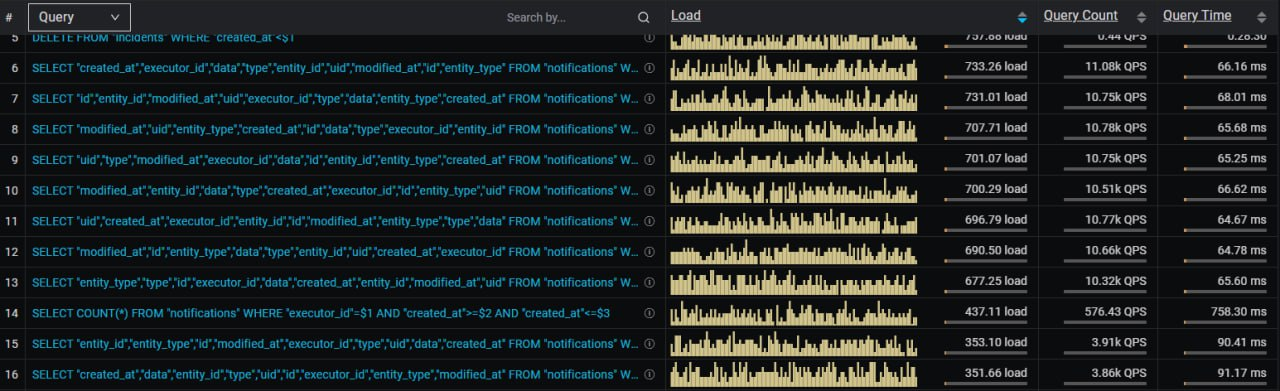

## Практическая часть

Создайте с помощью ORM 2 таблицы из схемы HR: Департаменты и Сотрудники.\
Они понадобятся нам на занятии по SQL.

На SQL это выглядело бы так:
```
CREATE TABLE departments
    ( department_id    INTEGER PRIMARY KEY
    , department_name  VARCHAR(30) NOT NULL
    , manager_id       INTEGER
    , location_id      INTEGER
) ;
	
CREATE TABLE employees
    ( employee_id    INTEGER PRIMARY KEY
    , first_name     VARCHAR(20)
    , last_name      VARCHAR(25) NOT NULL
    , email          VARCHAR(25) NOT NULL
    , phone_number   VARCHAR(20)
    , hire_date      TIMESTAMP  NOT NULL
    , job_id         VARCHAR(10)
    , salary         NUMERIC(8,2)
    , commission_pct NUMERIC(2,2)
    , manager_id     INTEGER REFERENCES employees(employee_id)
    , department_id  INTEGER REFERENCES departments(department_id)
    , CONSTRAINT     emp_salary_min
                     CHECK (salary > 0)
    , CONSTRAINT     emp_email_uk
                     UNIQUE (email)
) ;
```

In [8]:
from typing import List
from typing import Optional
from sqlalchemy import Column, ForeignKey, CheckConstraint, UniqueConstraint, select, text
from sqlalchemy import Integer, String, DateTime, Numeric
from sqlalchemy.orm import DeclarativeBase
from sqlalchemy.orm import relationship

class Base(DeclarativeBase):
    pass



In [9]:
from sqlalchemy import create_engine

# Подключение к базе данных PostgreSQL



In [10]:
from sqlalchemy import (
    create_engine, Column, Integer, String, ForeignKey,
    Numeric, DateTime, CheckConstraint, UniqueConstraint
)
from sqlalchemy.orm import declarative_base, relationship

Base = declarative_base()


class Department(Base):
    __tablename__ = 'departments'

    department_id = Column(Integer, primary_key=True)
    department_name = Column(String(30), nullable=False)
    manager_id = Column(Integer)
    location_id = Column(Integer)

    # Один департамент — много сотрудников
    employees = relationship("Employee", back_populates="department")


class Employee(Base):
    __tablename__ = 'employees'

    employee_id = Column(Integer, primary_key=True)
    first_name = Column(String(20))
    last_name = Column(String(25), nullable=False)
    email = Column(String(25), nullable=False, unique=True)
    phone_number = Column(String(20))
    hire_date = Column(DateTime, nullable=False)
    job_id = Column(String(10))
    salary = Column(Numeric(8, 2))
    commission_pct = Column(Numeric(2, 2))

    manager_id = Column(Integer, ForeignKey('employees.employee_id'))
    department_id = Column(Integer, ForeignKey('departments.department_id'))

    # Связи
    manager = relationship("Employee", remote_side=[
                           employee_id])  # сам себе менеджер
    department = relationship("Department", back_populates="employees")

    __table_args__ = (
        CheckConstraint('salary > 0', name='emp_salary_min'),
    )

Заполните таблицы данными.

In [11]:
sql = text('''
INSERT INTO departments VALUES ( 10,'Administration',200,1700);
INSERT INTO departments VALUES ( 20,'Marketing',201,1800);
INSERT INTO departments VALUES ( 30,'Purchasing',114,1700);
INSERT INTO departments VALUES ( 40,'Human Resources',203,2400);
INSERT INTO departments VALUES ( 50,'Shipping',121,1500);
INSERT INTO departments VALUES ( 60,'IT',103,1400);
INSERT INTO departments VALUES ( 70,'Public Relations',204,2700);
INSERT INTO departments VALUES ( 80,'Sales',145,2500);
INSERT INTO departments VALUES ( 90,'Executive',100,1700);
INSERT INTO departments VALUES ( 100,'Finance',108,1700);
INSERT INTO departments VALUES ( 110,'Accounting',205,1700);
INSERT INTO departments VALUES ( 120,'Treasury',NULL,1700);
INSERT INTO departments VALUES ( 130,'Corporate Tax',NULL,1700);
INSERT INTO departments VALUES ( 140,'Control And Credit',NULL,1700);
INSERT INTO departments VALUES ( 150,'Shareholder Services',NULL,1700);
INSERT INTO departments VALUES ( 160,'Benefits',NULL,1700);
INSERT INTO departments VALUES ( 170,'Manufacturing',NULL,1700);
INSERT INTO departments VALUES ( 180,'Construction',NULL,1700);
INSERT INTO departments VALUES ( 190,'Contracting',NULL,1700);
INSERT INTO departments VALUES ( 200,'Operations',NULL,1700);
INSERT INTO departments VALUES ( 210,'IT Support',NULL,1700);
INSERT INTO departments VALUES ( 220,'NOC',NULL,1700);
INSERT INTO departments VALUES ( 230,'IT Helpdesk',NULL,1700);
INSERT INTO departments VALUES ( 240,'Government Sales',NULL,1700);
INSERT INTO departments VALUES ( 250,'Retail Sales',NULL,1700);
INSERT INTO departments VALUES ( 260,'Recruiting',NULL,1700);
INSERT INTO departments VALUES ( 270,'Payroll',NULL,1700);

INSERT INTO employees VALUES ( 100,'Steven','King','SKING','515.123.4567',TO_DATE('17-JUN-1987', 'dd-MON-yyyy'),'AD_PRES',24000,0.0,NULL,90);
INSERT INTO employees VALUES ( 101,'Neena','Kochhar','NKOCHHAR','515.123.4568',TO_DATE('21-SEP-1989', 'dd-MON-yyyy'),'AD_VP',17000,0.0,100,90);
INSERT INTO employees VALUES ( 102,'Lex','De Haan','LDEHAAN','515.123.4569',TO_DATE('13-JAN-1993', 'dd-MON-yyyy'),'AD_VP',17000,0.0,100,90);
INSERT INTO employees VALUES ( 103,'Alexander','Hunold','AHUNOLD','590.423.4567',TO_DATE('03-JAN-1990', 'dd-MON-yyyy'),'IT_PROG',9000,NULL,102,60);
INSERT INTO employees VALUES ( 104,'Bruce','Ernst','BERNST','590.423.4568',TO_DATE('21-MAY-1991', 'dd-MON-yyyy'),'IT_PROG',6000,NULL,103,60);
INSERT INTO employees VALUES ( 105,'David','Austin','DAUSTIN','590.423.4569',TO_DATE('25-JUN-1997', 'dd-MON-yyyy'),'IT_PROG',4800,NULL,103,60);
INSERT INTO employees VALUES ( 106,'Valli','Pataballa','VPATABAL','590.423.4560',TO_DATE('05-FEB-1998', 'dd-MON-yyyy'),'IT_PROG',4800,NULL,103,60);
INSERT INTO employees VALUES ( 107,'Diana','Lorentz','DLORENTZ','590.423.5567',TO_DATE('07-FEB-1999', 'dd-MON-yyyy'),'IT_PROG',4200,NULL,103,60);
INSERT INTO employees VALUES ( 108,'Nancy','Greenberg','NGREENBE','515.124.4569',TO_DATE('17-AUG-1994', 'dd-MON-yyyy'),'FI_MGR',12000,NULL,101,100);
INSERT INTO employees VALUES ( 109,'Daniel','Faviet','DFAVIET','515.124.4169',TO_DATE('16-AUG-1994', 'dd-MON-yyyy'),'FI_ACCOUNT',9000,NULL,108,100);
INSERT INTO employees VALUES ( 110,'John','Chen','JCHEN','515.124.4269',TO_DATE('28-SEP-1997', 'dd-MON-yyyy'),'FI_ACCOUNT',8200,NULL,108,100);
INSERT INTO employees VALUES ( 111,'Ismael','Sciarra','ISCIARRA','515.124.4369',TO_DATE('30-SEP-1997', 'dd-MON-yyyy'),'FI_ACCOUNT',7700,NULL,108,100);
INSERT INTO employees VALUES ( 112,'Jose Manuel','Urman','JMURMAN','515.124.4469',TO_DATE('07-MAR-1998', 'dd-MON-yyyy'),'FI_ACCOUNT',7800,NULL,108,100);
INSERT INTO employees VALUES ( 113,'Luis','Popp','LPOPP','515.124.4567',TO_DATE('07-DEC-1999', 'dd-MON-yyyy'),'FI_ACCOUNT',6900,NULL,108,100);
INSERT INTO employees VALUES ( 114,'Den','Raphaely','DRAPHEAL','515.127.4561',TO_DATE('07-DEC-1994', 'dd-MON-yyyy'),'PU_MAN',11000,NULL,100,30);
INSERT INTO employees VALUES ( 115,'Alexander','Khoo','AKHOO','515.127.4562',TO_DATE('18-MAY-1995', 'dd-MON-yyyy'),'PU_CLERK',3100,NULL,114,30);
INSERT INTO employees VALUES ( 116,'Shelli','Baida','SBAIDA','515.127.4563',TO_DATE('24-DEC-1997', 'dd-MON-yyyy'),'PU_CLERK',2900,NULL,114,30);
INSERT INTO employees VALUES ( 117,'Sigal','Tobias','STOBIAS','515.127.4564',TO_DATE('24-JUL-1997', 'dd-MON-yyyy'),'PU_CLERK',2800,NULL,114,30);
INSERT INTO employees VALUES ( 118,'Guy','Himuro','GHIMURO','515.127.4565',TO_DATE('15-NOV-1998', 'dd-MON-yyyy'),'PU_CLERK',2600,NULL,114,30);
INSERT INTO employees VALUES ( 119,'Karen','Colmenares','KCOLMENA','515.127.4566',TO_DATE('10-AUG-1999', 'dd-MON-yyyy'),'PU_CLERK',2500,NULL,114,30);
INSERT INTO employees VALUES ( 120,'Matthew','Weiss','MWEISS','650.123.1234',TO_DATE('18-JUL-1996', 'dd-MON-yyyy'),'ST_MAN',8000,NULL,100,50);
INSERT INTO employees VALUES ( 121,'Adam','Fripp','AFRIPP','650.123.2234',TO_DATE('10-APR-1997', 'dd-MON-yyyy'),'ST_MAN',8200,NULL,100,50);
INSERT INTO employees VALUES ( 122,'Payam','Kaufling','PKAUFLIN','650.123.3234',TO_DATE('01-MAY-1995', 'dd-MON-yyyy'),'ST_MAN',7900,NULL,100,50);
INSERT INTO employees VALUES ( 123,'Shanta','Vollman','SVOLLMAN','650.123.4234',TO_DATE('10-OCT-1997', 'dd-MON-yyyy'),'ST_MAN',6500,NULL,100,50);
INSERT INTO employees VALUES ( 124,'Kevin','Mourgos','KMOURGOS','650.123.5234',TO_DATE('16-NOV-1999', 'dd-MON-yyyy'),'ST_MAN',5800,NULL,100,50);
INSERT INTO employees VALUES ( 125,'Julia','Nayer','JNAYER','650.124.1214',TO_DATE('16-JUL-1997', 'dd-MON-yyyy'),'ST_CLERK',3200,NULL,120,50);
INSERT INTO employees VALUES ( 126,'Irene','Mikkilineni','IMIKKILI','650.124.1224',TO_DATE('28-SEP-1998', 'dd-MON-yyyy'),'ST_CLERK',2700,NULL,120,50);
INSERT INTO employees VALUES ( 127,'James','Landry','JLANDRY','650.124.1334',TO_DATE('14-JAN-1999', 'dd-MON-yyyy'),'ST_CLERK',2400,NULL,120,50);
INSERT INTO employees VALUES ( 128,'Steven','Markle','SMARKLE','650.124.1434',TO_DATE('08-MAR-2000', 'dd-MON-yyyy'),'ST_CLERK',2200,NULL,120,50);
INSERT INTO employees VALUES ( 129,'Laura','Bissot','LBISSOT','650.124.5234',TO_DATE('20-AUG-1997', 'dd-MON-yyyy'),'ST_CLERK',3300,NULL,121,50);
INSERT INTO employees VALUES ( 130,'Mozhe','Atkinson','MATKINSO','650.124.6234',TO_DATE('30-OCT-1997', 'dd-MON-yyyy'),'ST_CLERK',2800,NULL,121,50);
INSERT INTO employees VALUES ( 131,'James','Marlow','JAMRLOW','650.124.7234',TO_DATE('16-FEB-1997', 'dd-MON-yyyy'),'ST_CLERK',2500,NULL,121,50);
INSERT INTO employees VALUES ( 132,'TJ','Olson','TJOLSON','650.124.8234',TO_DATE('10-APR-1999', 'dd-MON-yyyy'),'ST_CLERK',2100,NULL,121,50);
INSERT INTO employees VALUES ( 133,'Jason','Mallin','JMALLIN','650.127.1934',TO_DATE('14-JUN-1996', 'dd-MON-yyyy'),'ST_CLERK',3300,NULL,122,50);
INSERT INTO employees VALUES ( 134,'Michael','Rogers','MROGERS','650.127.1834',TO_DATE('26-AUG-1998', 'dd-MON-yyyy'),'ST_CLERK',2900,NULL,122,50);
INSERT INTO employees VALUES ( 135,'Ki','Gee','KGEE','650.127.1734',TO_DATE('12-DEC-1999', 'dd-MON-yyyy'),'ST_CLERK',2400,NULL,122,50);
INSERT INTO employees VALUES ( 136,'Hazel','Philtanker','HPHILTAN','650.127.1634',TO_DATE('06-FEB-2000', 'dd-MON-yyyy'),'ST_CLERK',2200,NULL,122,50);
INSERT INTO employees VALUES ( 137,'Renske','Ladwig','RLADWIG','650.121.1234',TO_DATE('14-JUL-1995', 'dd-MON-yyyy'),'ST_CLERK',3600,NULL,123,50);
INSERT INTO employees VALUES ( 138,'Stephen','Stiles','SSTILES','650.121.2034',TO_DATE('26-OCT-1997', 'dd-MON-yyyy'),'ST_CLERK',3200,NULL,123,50);
INSERT INTO employees VALUES ( 139,'John','Seo','JSEO','650.121.2019',TO_DATE('12-FEB-1998', 'dd-MON-yyyy'),'ST_CLERK',2700,NULL,123,50);
INSERT INTO employees VALUES ( 140,'Joshua','Patel','JPATEL','650.121.1834',TO_DATE('06-APR-1998', 'dd-MON-yyyy'),'ST_CLERK',2500,NULL,123,50);
INSERT INTO employees VALUES ( 141,'Trenna','Rajs','TRAJS','650.121.8009',TO_DATE('17-OCT-1995', 'dd-MON-yyyy'),'ST_CLERK',3500,NULL,124,50);
INSERT INTO employees VALUES ( 142,'Curtis','Davies','CDAVIES','650.121.2994',TO_DATE('29-JAN-1997', 'dd-MON-yyyy'),'ST_CLERK',3100,NULL,124,50);
INSERT INTO employees VALUES ( 143,'Randall','Matos','RMATOS','650.121.2874',TO_DATE('15-MAR-1998', 'dd-MON-yyyy'),'ST_CLERK',2600,NULL,124,50);
INSERT INTO employees VALUES ( 144,'Peter','Vargas','PVARGAS','650.121.2004',TO_DATE('09-JUL-1998', 'dd-MON-yyyy'),'ST_CLERK',2500,NULL,124,50);
INSERT INTO employees VALUES ( 145,'John','Russell','JRUSSEL','011.44.1344.429268',TO_DATE('01-OCT-1996', 'dd-MON-yyyy'),'SA_MAN',14000,.4,100,80);
INSERT INTO employees VALUES ( 146,'Karen','Partners','KPARTNER','011.44.1344.467268',TO_DATE('05-JAN-1997', 'dd-MON-yyyy'),'SA_MAN',13500,.3,100,80);
INSERT INTO employees VALUES ( 147,'Alberto','Errazuriz','AERRAZUR','011.44.1344.429278',TO_DATE('10-MAR-1997', 'dd-MON-yyyy'),'SA_MAN',12000,.3,100,80);
INSERT INTO employees VALUES ( 148,'Gerald','Cambrault','GCAMBRAU','011.44.1344.619268',TO_DATE('15-OCT-1999', 'dd-MON-yyyy'),'SA_MAN',11000,.3,100,80);
INSERT INTO employees VALUES ( 149,'Eleni','Zlotkey','EZLOTKEY','011.44.1344.429018',TO_DATE('29-JAN-2000', 'dd-MON-yyyy'),'SA_MAN',10500,.2,100,80);
INSERT INTO employees VALUES ( 150,'Peter','Tucker','PTUCKER','011.44.1344.129268',TO_DATE('30-JAN-1997', 'dd-MON-yyyy'),'SA_REP',10000,.3,145,80);
INSERT INTO employees VALUES ( 151,'David','Bernstein','DBERNSTE','011.44.1344.345268',TO_DATE('24-MAR-1997', 'dd-MON-yyyy'),'SA_REP',9500,.25,145,80);
INSERT INTO employees VALUES ( 152,'Peter','Hall','PHALL','011.44.1344.478968',TO_DATE('20-AUG-1997', 'dd-MON-yyyy'),'SA_REP',9000,.25,145,80);
INSERT INTO employees VALUES ( 153,'Christopher','Olsen','COLSEN','011.44.1344.498718',TO_DATE('30-MAR-1998', 'dd-MON-yyyy'),'SA_REP',8000,.2,145,80);
INSERT INTO employees VALUES ( 154,'Nanette','Cambrault','NCAMBRAU','011.44.1344.987668',TO_DATE('09-DEC-1998', 'dd-MON-yyyy'),'SA_REP',7500,.2,145,80);
INSERT INTO employees VALUES ( 155,'Oliver','Tuvault','OTUVAULT','011.44.1344.486508',TO_DATE('23-NOV-1999', 'dd-MON-yyyy'),'SA_REP',7000,.15,145,80);
INSERT INTO employees VALUES ( 156,'Janette','King','JKING','011.44.1345.429268',TO_DATE('30-JAN-1996', 'dd-MON-yyyy'),'SA_REP',10000,.35,146,80);
INSERT INTO employees VALUES ( 157,'Patrick','Sully','PSULLY','011.44.1345.929268',TO_DATE('04-MAR-1996', 'dd-MON-yyyy'),'SA_REP',9500,.35,146,80);
INSERT INTO employees VALUES ( 158,'Allan','McEwen','AMCEWEN','011.44.1345.829268',TO_DATE('01-AUG-1996', 'dd-MON-yyyy'),'SA_REP',9000,.35,146,80);
INSERT INTO employees VALUES ( 159,'Lindsey','Smith','LSMITH','011.44.1345.729268',TO_DATE('10-MAR-1997', 'dd-MON-yyyy'),'SA_REP',8000,.3,146,80);
INSERT INTO employees VALUES ( 160,'Louise','Doran','LDORAN','011.44.1345.629268',TO_DATE('15-DEC-1997', 'dd-MON-yyyy'),'SA_REP',7500,.3,146,80);
INSERT INTO employees VALUES ( 161,'Sarath','Sewall','SSEWALL','011.44.1345.529268',TO_DATE('03-NOV-1998', 'dd-MON-yyyy'),'SA_REP',7000,.25,146,80);
INSERT INTO employees VALUES ( 162,'Clara','Vishney','CVISHNEY','011.44.1346.129268',TO_DATE('11-NOV-1997', 'dd-MON-yyyy'),'SA_REP',10500,.25,147,80);
INSERT INTO employees VALUES ( 163,'Danielle','Greene','DGREENE','011.44.1346.229268',TO_DATE('19-MAR-1999', 'dd-MON-yyyy'),'SA_REP',9500,.15,147,80);
INSERT INTO employees VALUES ( 164,'Mattea','Marvins','MMARVINS','011.44.1346.329268',TO_DATE('24-JAN-2000', 'dd-MON-yyyy'),'SA_REP',7200,.10,147,80);
INSERT INTO employees VALUES ( 165,'David','Lee','DLEE','011.44.1346.529268',TO_DATE('23-FEB-2000', 'dd-MON-yyyy'),'SA_REP',6800,.1,147,80);
INSERT INTO employees VALUES ( 166,'Sundar','Ande','SANDE','011.44.1346.629268',TO_DATE('24-MAR-2000', 'dd-MON-yyyy'),'SA_REP',6400,.10,147,80);
INSERT INTO employees VALUES ( 167,'Amit','Banda','ABANDA','011.44.1346.729268',TO_DATE('21-APR-2000', 'dd-MON-yyyy'),'SA_REP',6200,.10,147,80);
INSERT INTO employees VALUES ( 168,'Lisa','Ozer','LOZER','011.44.1343.929268',TO_DATE('11-MAR-1997', 'dd-MON-yyyy'),'SA_REP',11500,.25,148,80);
INSERT INTO employees VALUES ( 169,'Harrison','Bloom','HBLOOM','011.44.1343.829268',TO_DATE('23-MAR-1998', 'dd-MON-yyyy'),'SA_REP',10000,.20,148,80);
INSERT INTO employees VALUES ( 170,'Tayler','Fox','TFOX','011.44.1343.729268',TO_DATE('24-JAN-1998', 'dd-MON-yyyy'),'SA_REP',9600,.20,148,80);
INSERT INTO employees VALUES ( 171,'William','Smith','WSMITH','011.44.1343.629268',TO_DATE('23-FEB-1999', 'dd-MON-yyyy'),'SA_REP',7400,.15,148,80);
INSERT INTO employees VALUES ( 172,'Elizabeth','Bates','EBATES','011.44.1343.529268',TO_DATE('24-MAR-1999', 'dd-MON-yyyy'),'SA_REP',7300,.15,148,80);
INSERT INTO employees VALUES ( 173,'Sundita','Kumar','SKUMAR','011.44.1343.329268',TO_DATE('21-APR-2000', 'dd-MON-yyyy'),'SA_REP',6100,.10,148,80);
INSERT INTO employees VALUES ( 174,'Ellen','Abel','EABEL','011.44.1644.429267',TO_DATE('11-MAY-1996', 'dd-MON-yyyy'),'SA_REP',11000,.30,149,80);
INSERT INTO employees VALUES ( 175,'Alyssa','Hutton','AHUTTON','011.44.1644.429266',TO_DATE('19-MAR-1997', 'dd-MON-yyyy'),'SA_REP',8800,.25,149,80);
INSERT INTO employees VALUES ( 176,'Jonathon','Taylor','JTAYLOR','011.44.1644.429265',TO_DATE('24-MAR-1998', 'dd-MON-yyyy'),'SA_REP',8600,.20,149,80);
INSERT INTO employees VALUES ( 177,'Jack','Livingston','JLIVINGS','011.44.1644.429264',TO_DATE('23-APR-1998', 'dd-MON-yyyy'),'SA_REP',8400,.20,149,80);
INSERT INTO employees VALUES ( 178,'Kimberely','Grant','KGRANT','011.44.1644.429263',TO_DATE('24-MAY-1999', 'dd-MON-yyyy'),'SA_REP',7000,.15,149,NULL);
INSERT INTO employees VALUES ( 179,'Charles','Johnson','CJOHNSON','011.44.1644.429262',TO_DATE('04-JAN-2000', 'dd-MON-yyyy'),'SA_REP',6200,.10,149,80);
INSERT INTO employees VALUES ( 180,'Winston','Taylor','WTAYLOR','650.507.9876',TO_DATE('24-JAN-1998', 'dd-MON-yyyy'),'SH_CLERK',3200,NULL,120,50);
INSERT INTO employees VALUES ( 181,'Jean','Fleaur','JFLEAUR','650.507.9877',TO_DATE('23-FEB-1998', 'dd-MON-yyyy'),'SH_CLERK',3100,NULL,120,50);
INSERT INTO employees VALUES ( 182,'Martha','Sullivan','MSULLIVA','650.507.9878',TO_DATE('21-JUN-1999', 'dd-MON-yyyy'),'SH_CLERK',2500,NULL,120,50);
INSERT INTO employees VALUES ( 183,'Girard','Geoni','GGEONI','650.507.9879',TO_DATE('03-FEB-2000', 'dd-MON-yyyy'),'SH_CLERK',2800,NULL,120,50);
INSERT INTO employees VALUES ( 184,'Nandita','Sarchand','NSARCHAN','650.509.1876',TO_DATE('27-JAN-1996', 'dd-MON-yyyy'),'SH_CLERK',4200,NULL,121,50);
INSERT INTO employees VALUES ( 185,'Alexis','Bull','ABULL','650.509.2876',TO_DATE('20-FEB-1997', 'dd-MON-yyyy'),'SH_CLERK',4100,NULL,121,50);
INSERT INTO employees VALUES ( 186,'Julia','Dellinger','JDELLING','650.509.3876',TO_DATE('24-JUN-1998', 'dd-MON-yyyy'),'SH_CLERK',3400,NULL,121,50);
INSERT INTO employees VALUES ( 187,'Anthony','Cabrio','ACABRIO','650.509.4876',TO_DATE('07-FEB-1999', 'dd-MON-yyyy'),'SH_CLERK',3000,NULL,121,50);
INSERT INTO employees VALUES ( 188,'Kelly','Chung','KCHUNG','650.505.1876',TO_DATE('14-JUN-1997', 'dd-MON-yyyy'),'SH_CLERK',3800,NULL,122,50);
INSERT INTO employees VALUES ( 189,'Jennifer','Dilly','JDILLY','650.505.2876',TO_DATE('13-AUG-1997', 'dd-MON-yyyy'),'SH_CLERK',3600,NULL,122,50);
INSERT INTO employees VALUES ( 190,'Timothy','Gates','TGATES','650.505.3876',TO_DATE('11-JUL-1998', 'dd-MON-yyyy'),'SH_CLERK',2900,NULL,122,50);
INSERT INTO employees VALUES ( 191,'Randall','Perkins','RPERKINS','650.505.4876',TO_DATE('19-DEC-1999', 'dd-MON-yyyy'),'SH_CLERK',2500,NULL,122,50);
INSERT INTO employees VALUES ( 192,'Sarah','Bell','SBELL','650.501.1876',TO_DATE('04-FEB-1996', 'dd-MON-yyyy'),'SH_CLERK',4000,NULL,123,50);
INSERT INTO employees VALUES ( 193,'Britney','Everett','BEVERETT','650.501.2876',TO_DATE('03-MAR-1997', 'dd-MON-yyyy'),'SH_CLERK',3900,NULL,123,50);
INSERT INTO employees VALUES ( 194,'Samuel','McCain','SMCCAIN','650.501.3876',TO_DATE('01-JUL-1998', 'dd-MON-yyyy'),'SH_CLERK',3200,NULL,123,50);
INSERT INTO employees VALUES ( 195,'Vance','Jones','VJONES','650.501.4876',TO_DATE('17-MAR-1999', 'dd-MON-yyyy'),'SH_CLERK',2800,NULL,123,50);
INSERT INTO employees VALUES ( 196,'Alana','Walsh','AWALSH','650.507.9811',TO_DATE('24-APR-1998', 'dd-MON-yyyy'),'SH_CLERK',3100,NULL,124,50);
INSERT INTO employees VALUES ( 197,'Kevin','Feeney','KFEENEY','650.507.9822',TO_DATE('23-MAY-1998', 'dd-MON-yyyy'),'SH_CLERK',3000,NULL,124,50);
INSERT INTO employees VALUES ( 198,'Donald','OConnell','DOCONNEL','650.507.9833',TO_DATE('21-JUN-1999', 'dd-MON-yyyy'),'SH_CLERK',2600,NULL,124,50);
INSERT INTO employees VALUES ( 199,'Douglas','Grant','DGRANT','650.507.9844',TO_DATE('13-JAN-2000', 'dd-MON-yyyy'),'SH_CLERK',2600,NULL,124,50);
INSERT INTO employees VALUES ( 200,'Jennifer','Whalen','JWHALEN','515.123.4444',TO_DATE('17-SEP-1987', 'dd-MON-yyyy'),'AD_ASST',4400,NULL,101,10);
INSERT INTO employees VALUES ( 201,'Michael','Hartstein','MHARTSTE','515.123.5555',TO_DATE('17-FEB-1996', 'dd-MON-yyyy'),'MK_MAN',13000,NULL,100,20);
INSERT INTO employees VALUES ( 202,'Pat','Fay','PFAY','603.123.6666',TO_DATE('17-AUG-1997', 'dd-MON-yyyy'),'MK_REP',6000,NULL,201,20);
INSERT INTO employees VALUES ( 203,'Susan','Mavris','SMAVRIS','515.123.7777',TO_DATE('07-JUN-1994', 'dd-MON-yyyy'),'HR_REP',6500,NULL,101,40);
INSERT INTO employees VALUES ( 204,'Hermann','Baer','HBAER','515.123.8888',TO_DATE('07-JUN-1994', 'dd-MON-yyyy'),'PR_REP',10000,NULL,101,70);
INSERT INTO employees VALUES ( 205,'Shelley','Higgins','SHIGGINS','515.123.8080',TO_DATE('07-JUN-1994', 'dd-MON-yyyy'),'AC_MGR',12000,NULL,101,110);
INSERT INTO employees VALUES ( 206,'William','Gietz','WGIETZ','515.123.8181',TO_DATE('07-JUN-1994', 'dd-MON-yyyy'),'AC_ACCOUNT',8300,NULL,205,110);
''')

Проверьте, что таблицы заполнены: